# Medicare Claims Analysis

Medicare is USA's largest government insurance program. It caters to US senior citizens aged 65+, and youths with disabilities. The program is adminstered by CMS (Center for Medicare and Medicaid Services). The data linked is from the CMS Website.


### Guidelines for the task
- Take the time to understand the business problem and to develop a thoughtful solution, we suggest taking a few hours to complete the task.
- Be prepared to talk through what you did during the task to a technical & non-technical audience.
- If there are parts of this EDA that you would do differently, or with more time, would try something else, please discuss these during the interview. 
- Please share code & relevant materials (slides, workbooks etc..) at least 24 hours prior to the interview



### Central Question: How does cost vary across different providers for different conditions?

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [35]:
%run helper_functions.py
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
slide_background_color = SLIDE_BACKGROUND_COLOR
def set_preferred_options():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
    plt.style.use('dark_background')
    plt.facecolor=(SLIDE_BACKGROUND_COLOR)
    matplotlib.rcParams['font.sans-serif'] = "Arial"
    matplotlib.rcParams['font.family'] = "sans-serif"
    # To suppress a setting with copy warning
    # https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
    pd.options.mode.chained_assignment = None 
set_preferred_options()

### 1 Read the data

In [4]:
def get_data(file_path, char_columns):
    dtype_options = {column: "str" for column in char_columns}
    df = pd.read_csv(file_path, dtype=dtype_options)
    return df

In [5]:
beneficiary_file_path = "./data/DE1_0_2009_Beneficiary_Summary_File_Sample_20.csv"
char_columns_in_beneficiary_data = [
    'BENE_SEX_IDENT_CD',
    'BENE_RACE_CD',
    'BENE_ESRD_IND',
    'SP_STATE_CODE',
    'SP_ALZHDMTA',
    'SP_CHF',
    'SP_CHRNKIDN',
    'SP_CNCR',
    'SP_COPD',
    'SP_DEPRESSN',
    'SP_DIABETES',
    'SP_ISCHMCHT',
    'SP_OSTEOPRS',
    'SP_RA_OA',
    'SP_STRKETIA'
]	


claims_file_path = "./data/DE1_0_2008_to_2010_Outpatient_Claims_Sample_20.csv"
char_columns_in_claims_data = [
    'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2',
    'ICD9_DGNS_CD_3','ICD9_DGNS_CD_4' ,'ICD9_DGNS_CD_5',
    'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8',
    'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10',
    'ICD9_PRCDR_CD_1', 'ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3',
    'ICD9_PRCDR_CD_4', 'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6'     
]



In [6]:
beneficiary_df = get_data(beneficiary_file_path, 
                          char_columns_in_beneficiary_data)
claims_df = get_data(claims_file_path,
                     char_columns_in_claims_data)

In [7]:
beneficiary_df = get_beneficiary_age(beneficiary_df,
                                     'BENE_BIRTH_DT',
                                     reference_date_str='20101212'
                                     )


### 2 Descriptive Graphs

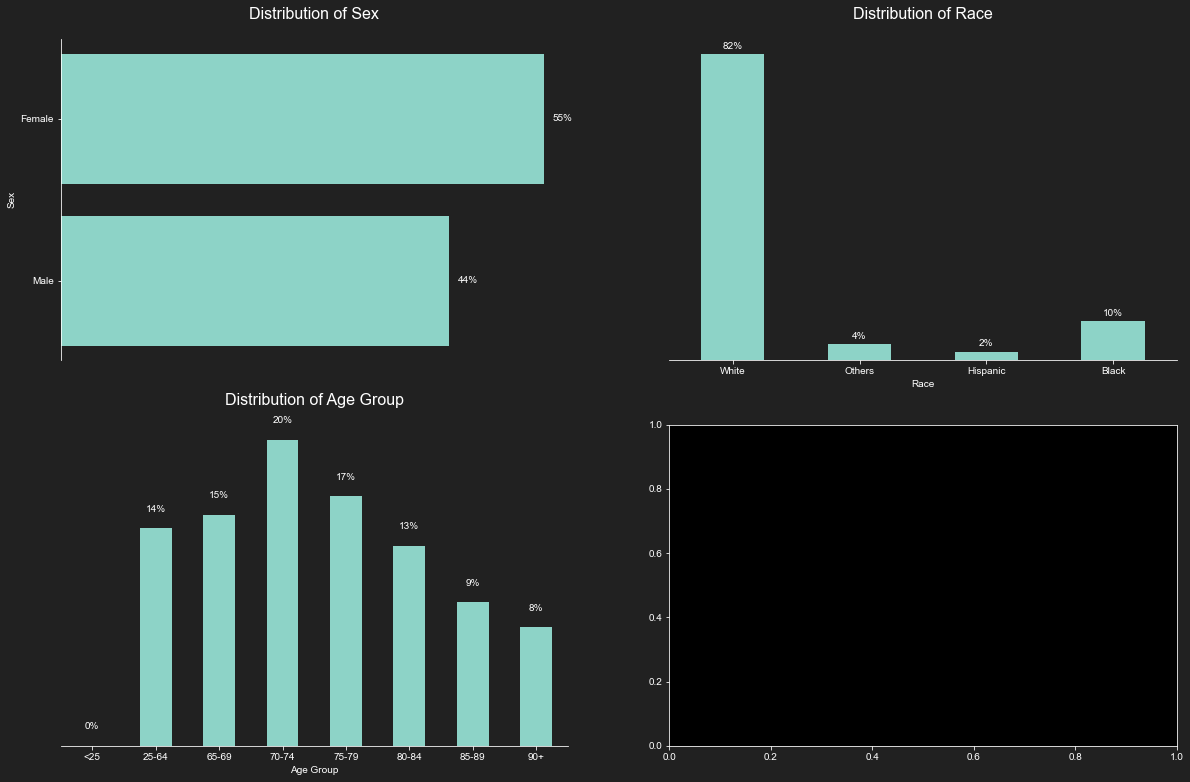

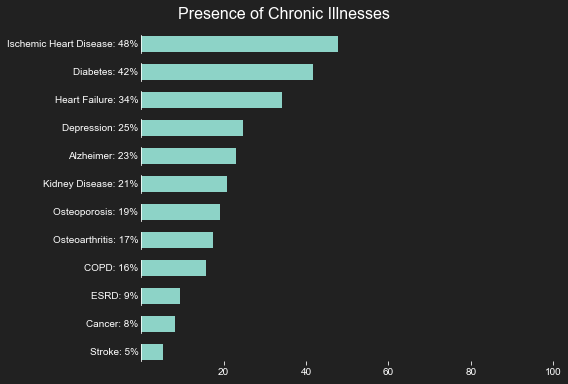

In [8]:
def generate_descriptive_graphs_beneficiary(beneficiary_df):
    sex_labels = {'1':'Male', '2':'Female'}
    race_labels = {'1': 'White', '2': 'Black', '3': 'Others', '5': 'Hispanic'}
    sp_conditions_map = {
    'Yes':'1',
    'No':'2'
    }
    esrd_conditions_map = {
        'No':'0',
        'Yes':'Y'
    }
    conditions_readable_map = {
        'BENE_ESRD_IND':['ESRD', esrd_conditions_map],
        'SP_ALZHDMTA':['Alzheimer', sp_conditions_map],
        'SP_CHF':['Heart Failure', sp_conditions_map],
        'SP_CHRNKIDN':['Kidney Disease', sp_conditions_map],
        'SP_CNCR':['Cancer', sp_conditions_map],
        'SP_COPD':['COPD', sp_conditions_map],
        'SP_DEPRESSN':['Depression', sp_conditions_map],
        'SP_DIABETES':['Diabetes', sp_conditions_map],
        'SP_ISCHMCHT':['Ischemic Heart Disease', sp_conditions_map],
        'SP_OSTEOPRS':['Osteoporosis', sp_conditions_map],
        'SP_RA_OA':['Osteoarthritis', sp_conditions_map],
        'SP_STRKETIA':['Stroke' , sp_conditions_map],
    }

    age_labels = {
        '1': '<25',
        '2': '25-64',
        '3': '65-69',
        '4': '70-74',
        '5': '75-79',
        '6': '80-84',
        '7': '85-89',
        '8': '90+',
    }
    fig, axs = plt.subplots(
        nrows=2,
        ncols=2,
        figsize=(20, 13),
        facecolor=SLIDE_BACKGROUND_COLOR
    )

    generate_horizontal_bar_graph(ax=axs[0, 0],
                                  df=beneficiary_df, 
                                  categorical_variable="BENE_SEX_IDENT_CD",
                                  chart_title="",
                                  variable_readable="Sex",
                                  variable_labels=sex_labels)
    
    generate_vertical_bar_graph(ax=axs[0, 1],
                                df=beneficiary_df, 
                                variable="BENE_RACE_CD",
                                chart_title="",
                                variable_readable="Race",
                                variable_labels=race_labels)
    
    generate_vertical_bar_graph(ax=axs[1, 0],
                                df=beneficiary_df, 
                                variable="age_group",
                                variable_readable="Age Group",
                                chart_title="",
                                variable_labels=age_labels)
    plt.show()
    generate_conditions_summary(beneficiary_df, conditions_readable_map)
    
generate_descriptive_graphs_beneficiary(beneficiary_df)

### 3 Data Quality checks

- Beneficiary data is unique at `DESYNPUF_ID` - which represents the beneficiary code/ patient code according to documentation${^1}$

- The claims data is not unique on `CLM_ID`. However it is unique at `CLM_ID` x `Segment` level.
Wherever segment = 2, most of the variables are `NaN`s, excepting Provider Institution. From looking at this data, my hypothesis is that the claims were amended, with a new Provider Info, or claim amount. For this analysis, I'm dropping the rows where the segment = 2, and most of the variables are `NaN`

- There are some claims where the `CLM_PMT_AMT` is negative, which can occur in
the following cases:
    - Where the beneficiary is charged a coinsurance amount and this is higher than the amount Medicare pays
    - Where the deductible exceeds the amount Medicare pays
    
    In both the above situations the claim amount does not represent the cost of the treatment, hence this has been removed from the dataset

- `MEDREIMB_OP` in the beneficiary dataset denotes the total annual medical Outpatient Reimbursement from Medicaid. There are some beneficiaries in the dataset that have negative due to similar reasons as for `CLM_PMT_AMT`. However these are not removed, as their could be non-negative claim amounts from the same benficiary. I've replaced negative values with
0 for this dataset.



In [9]:
duplicate_claims = claims_df[claims_df.duplicated(subset=['CLM_ID'], keep=False)]
print(f"Percentage of data removed due to duplicates:\
      {round(100* len(duplicate_claims)/len(claims_df), 2)}")

negative_claims = claims_df[claims_df['CLM_PMT_AMT'] < 0] 
print(f"Percentage of data removed due to Negative amounts:\
      {round(100* len(negative_claims)/len(claims_df), 2)}")

claims_df = claims_df.drop_duplicates(subset=['CLM_ID'])
claims_df = claims_df[claims_df['CLM_PMT_AMT'] >= 0]

beneficiary_df['MEDREIMB_OP'] = beneficiary_df['MEDREIMB_OP'].clip(lower=0)



Percentage of data removed due to duplicates:      2.73
Percentage of data removed due to Negative amounts:      0.33


### 4 New column creation
#### 4.1 For illness condition

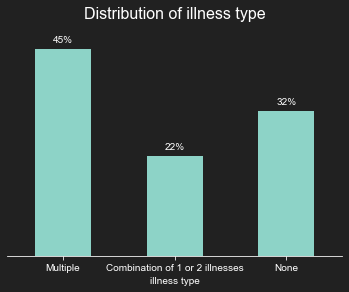

In [10]:
sp_conditions_map = {
'Yes':'1',
'No':'2'
}
esrd_conditions_map = {
    'No':'0',
    'Yes':'Y'
}
conditions_readable_map = {
    'BENE_ESRD_IND':['ESRD', esrd_conditions_map],
    'SP_ALZHDMTA':['Alzheimer', sp_conditions_map],
    'SP_CHF':['Heart Failure', sp_conditions_map],
    'SP_CHRNKIDN':['Kidney Disease', sp_conditions_map],
    'SP_CNCR':['Cancer', sp_conditions_map],
    'SP_COPD':['COPD', sp_conditions_map],
    'SP_DEPRESSN':['Depression', sp_conditions_map],
    'SP_DIABETES':['Diabetes', sp_conditions_map],
    'SP_ISCHMCHT':['Ischemic Heart Disease', sp_conditions_map],
    'SP_OSTEOPRS':['Osteoporosis', sp_conditions_map],
    'SP_RA_OA':['Osteoarthritis', sp_conditions_map],
    'SP_STRKETIA':['Stroke' , sp_conditions_map],
}


beneficiary_df['combined_condition'] = beneficiary_df.apply(combine_conditions, 
                                    columns_to_combine=conditions_readable_map, 
                                    axis=1)
beneficiary_df['combined_condition'].value_counts()
beneficiary_df = get_illness_var_type(beneficiary_df)
generate_vertical_bar_graph(df=beneficiary_df, 
                        variable="illness_var_type",
                        variable_readable="illness type")


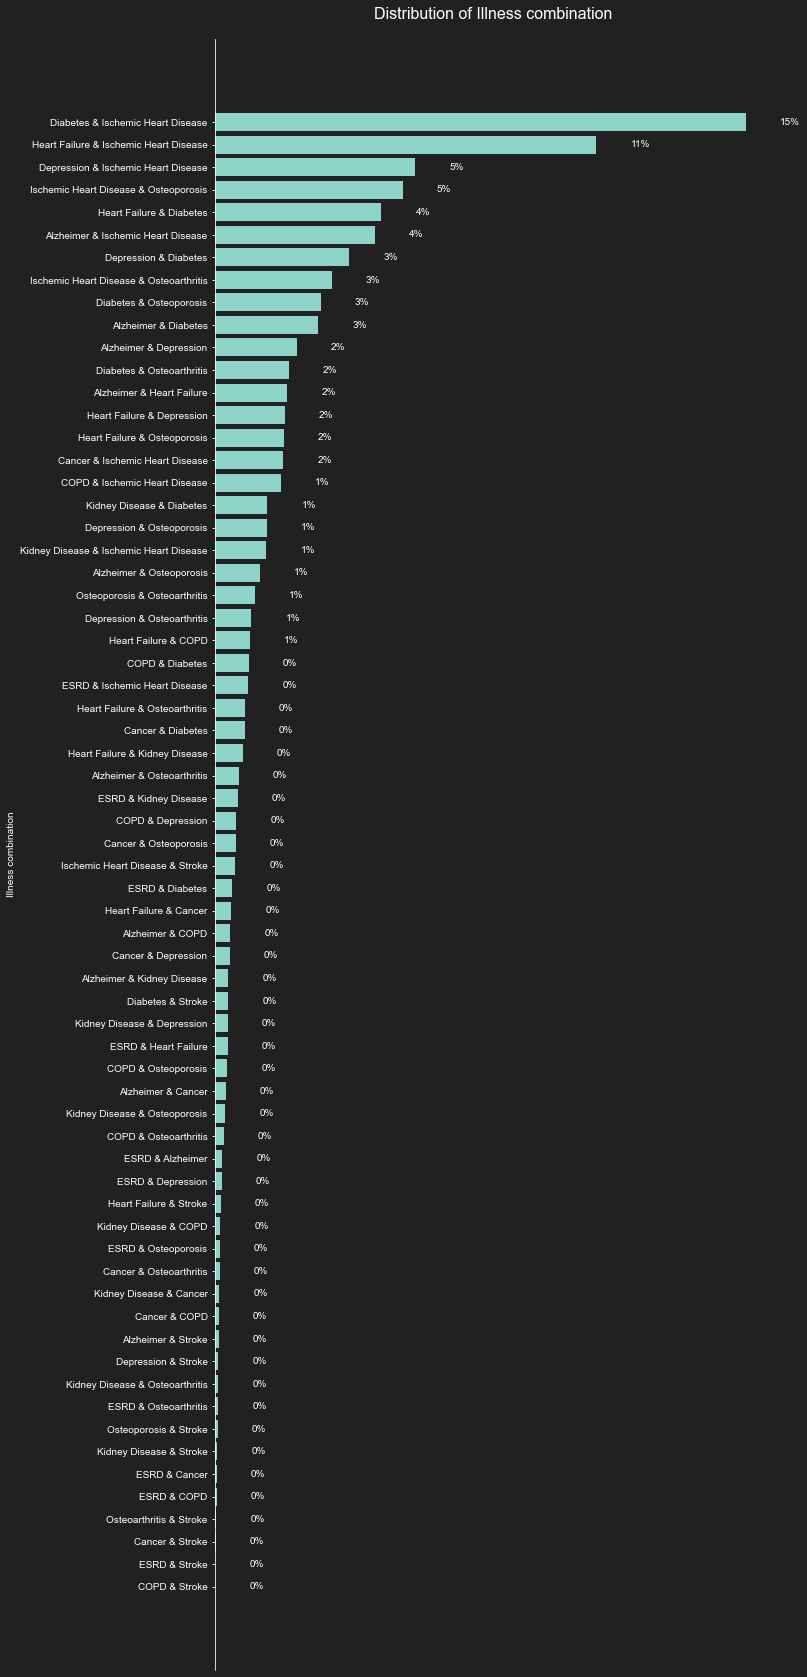

In [11]:
illness_combination_df = beneficiary_df[
    beneficiary_df['combined_condition'].str.contains('\&')
    ]
fig, ax = plt.subplots(figsize=(10, 30), facecolor=SLIDE_BACKGROUND_COLOR)
generate_horizontal_bar_graph(ax=ax,
                              df=illness_combination_df,
                              categorical_variable="combined_condition", 
                              chart_title="", 
                              variable_readable="Illness combination")
plt.show()

### 5 Data join

In [12]:
print(f"# of rows in beneficiary data: {len(beneficiary_df)}")
print(f"# of rows in claims data:  {len(claims_df)}")
beneficiary_claims_df = pd.merge(beneficiary_df, claims_df, 
                                 on='DESYNPUF_ID', how='inner')
print(f'# of rows in joined data: {len(beneficiary_claims_df)}')

# of rows in beneficiary data: 114641
# of rows in claims data:  776670
# of rows in joined data: 774693


In [13]:
merged_df = pd.merge(beneficiary_df, claims_df, on='DESYNPUF_ID', how='outer', indicator=True)

claims_missing_beneficiary = merged_df[merged_df['_merge'] == 'right_only']
beneficiary_missing_claims = merged_df[merged_df['_merge'] == 'left_only']
print(f"Beneficiaries without claims: {len(beneficiary_missing_claims)}")
print(f" %Beneficiaries without claims:\
      {round(100 * len(beneficiary_missing_claims)/len(beneficiary_df), 2)}")
print(f"Claims without beneficiaries: {len(claims_missing_beneficiary)}")
print(f" %Claims without beneficiaries:\
      {round(100 * len(claims_missing_beneficiary)/len(claims_df), 2)}")

Beneficiaries without claims: 30077
 %Beneficiaries without claims:      26.24
Claims without beneficiaries: 1977
 %Claims without beneficiaries:      0.25


In [14]:
beneficiary_missing_claims['TOTAL_SUM'] = (
    beneficiary_missing_claims['MEDREIMB_IP'] + 
    beneficiary_missing_claims['MEDREIMB_CAR']
)

conditions = [
    beneficiary_missing_claims['TOTAL_SUM'] > 0,
    beneficiary_missing_claims['combined_condition'] == 'None'
]

choices = [
    "Has other claims",
    "No illnesses"
]

beneficiary_missing_claims.loc[:, 'missing_reason'] = np.select(
    conditions, choices, default="No claims")

print(beneficiary_missing_claims['missing_reason']
      .value_counts(normalize=True) * 100)


No illnesses       68.41
Has other claims   31.17
No claims           0.42
Name: missing_reason, dtype: float64


#### 5.1 Data quality after join
- 26% of beneficiaries do not have any Out patient claims, 68% of them 
has no chronic illness, and another 31% have had Medicare reimbursements in 
other type of claims such as In-patient, or prescription costs. This leaves <1%
that do not have any claims and have had some illness.
- There are ~2k OP claims without beneficiaries, which is 0.25% of the data.

Onward with the remaining analysis!

#### 5.2 Data Summary after join


In [15]:
def get_cost_per_member(df, 
                        variable_name='cost_per_member'):
    '''
    Given a dataframe,
    adds a column for cost_per_member
    '''
    df[variable_name] = (df['total_cost']/
                         df['beneficiary_count'])
    df = df.sort_values(by=variable_name, 
                        ascending=False) 
    return df

##### 5.2.1 Cost per Member

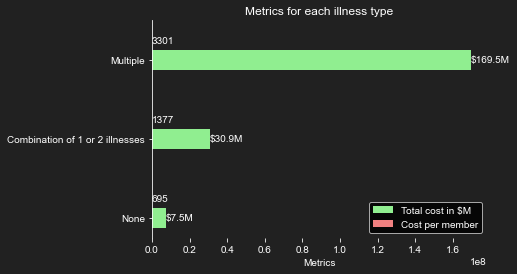

In [48]:
condition_type_grouped_df = (beneficiary_claims_df
                             .groupby('illness_var_type')
                             .agg(
                                total_cost=('CLM_PMT_AMT', 'sum'),
                                beneficiary_count=('DESYNPUF_ID', 'nunique'),  
                                claim_count=('CLM_ID', 'count')  
                                )
                             .reset_index())
# condition_type_grouped_df['total_cost'] /= 1000000 
condition_type_grouped_df = get_cost_per_member(condition_type_grouped_df,
                                                'cost_per_member_per_illness')
fig, ax = plt.subplots(figsize=(6, 4), facecolor=SLIDE_BACKGROUND_COLOR)
generate_clustered_column(condition_type_grouped_df,
                          'illness_var_type', 
                          'cost_per_member_per_illness', 
                          'Cost per member',
                          'total_cost',
                          'Total cost in $M',
                           "Metrics for each illness type",
                          ax=ax,)
for i, v in enumerate(condition_type_grouped_df['total_cost']):
   ax.text(v + 1,
            i + 0.25, 
            '${:,.1f}M'.format(v/1000000), 
            ha='left', 
            va='center',
            fontsize=10)



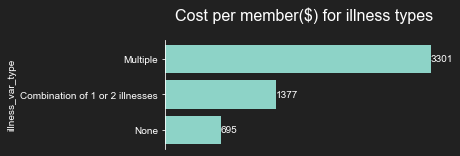

In [17]:
fig, ax = plt.subplots(figsize=(5, 2), facecolor=SLIDE_BACKGROUND_COLOR)
generate_horizontal_bar_graph(ax=ax,
                                df=condition_type_grouped_df, 
                                categorical_variable="illness_var_type",
                                variable_x="cost_per_member_per_illness",
                                chart_title="Cost per member($) for illness types")

##### 5.2.2 Illness combination with highest cost
- Most expenses from illness combination: Ischemic Heart Disease + Diabetes
    - This is expected as we saw earlier that this is the most commonly occuring condition.

In [54]:

condition_grouped_df = beneficiary_claims_df.groupby('combined_condition').agg(
    total_cost=('CLM_PMT_AMT', 'sum'),
    beneficiary_count=('DESYNPUF_ID', 'nunique'),  
    claim_count=('CLM_ID', 'count')  
).reset_index()
top_illnesses = (condition_grouped_df
                 .sort_values(by='total_cost', ascending=False)
                 .head(10)
                 )
top_illnesses = get_cost_per_member(top_illnesses,
                                    'cost_per_member')
top_illnesses.sort_values(by='total_cost', ascending=False, inplace=True)
top_illnesses = get_2combination_illness(top_illnesses)
top_illnesses.columns = [
    'Condition',
    'Total Cost',
    '# beneficiaries',
    '# claims',
    'Cost per member'

]

top_illnesses.style.format(
    {'Total Cost': apply_currency_formatting,
     '# beneficiaries': '{:,.0f}',
     '# claims': '{:,.0f}',
     'Cost per member': '{:,.0f}' 
     }
)



,Condition,Total Cost,# beneficiaries,# claims,Cost per member
59,Ischemic Heart Disease,"$4,154,450","3,409","18,609","1,219"
33,Diabetes & Ischemic Heart Disease,"$2,941,930","1,856","13,642","1,585"
32,Diabetes,"$2,250,410","1,673","10,729","1,345"
54,Heart Failure & Ischemic Heart Disease,"$1,891,530","1,286","8,884","1,471"
26,Depression,"$1,412,450","1,186","6,623","1,191"
49,Heart Failure,"$1,158,360","1,131","5,641","1,024"
28,Depression & Ischemic Heart Disease,"$1,102,670",694,"4,906","1,589"
76,Osteoporosis,"$1,066,700",972,"5,184","1,097"


##### 5.2.3 Illness combination with highest cost per member
- Initially, we can observe that End Stage Renal Disease (ESRD) combined with Cancer or Stroke has the highest cost per member
- However, these are not conditions that co-occur frequently, with less than 10 
beneficiaries having them 
- A better representation of this dataset is on the right plot, after removing 
conditions that have very few persons affected by it
- After this, we see that Cancer + Osteoporosis is the most expensive combination from 
a cost per member perspective
- Another observation is that costs vary from $2315 to $912

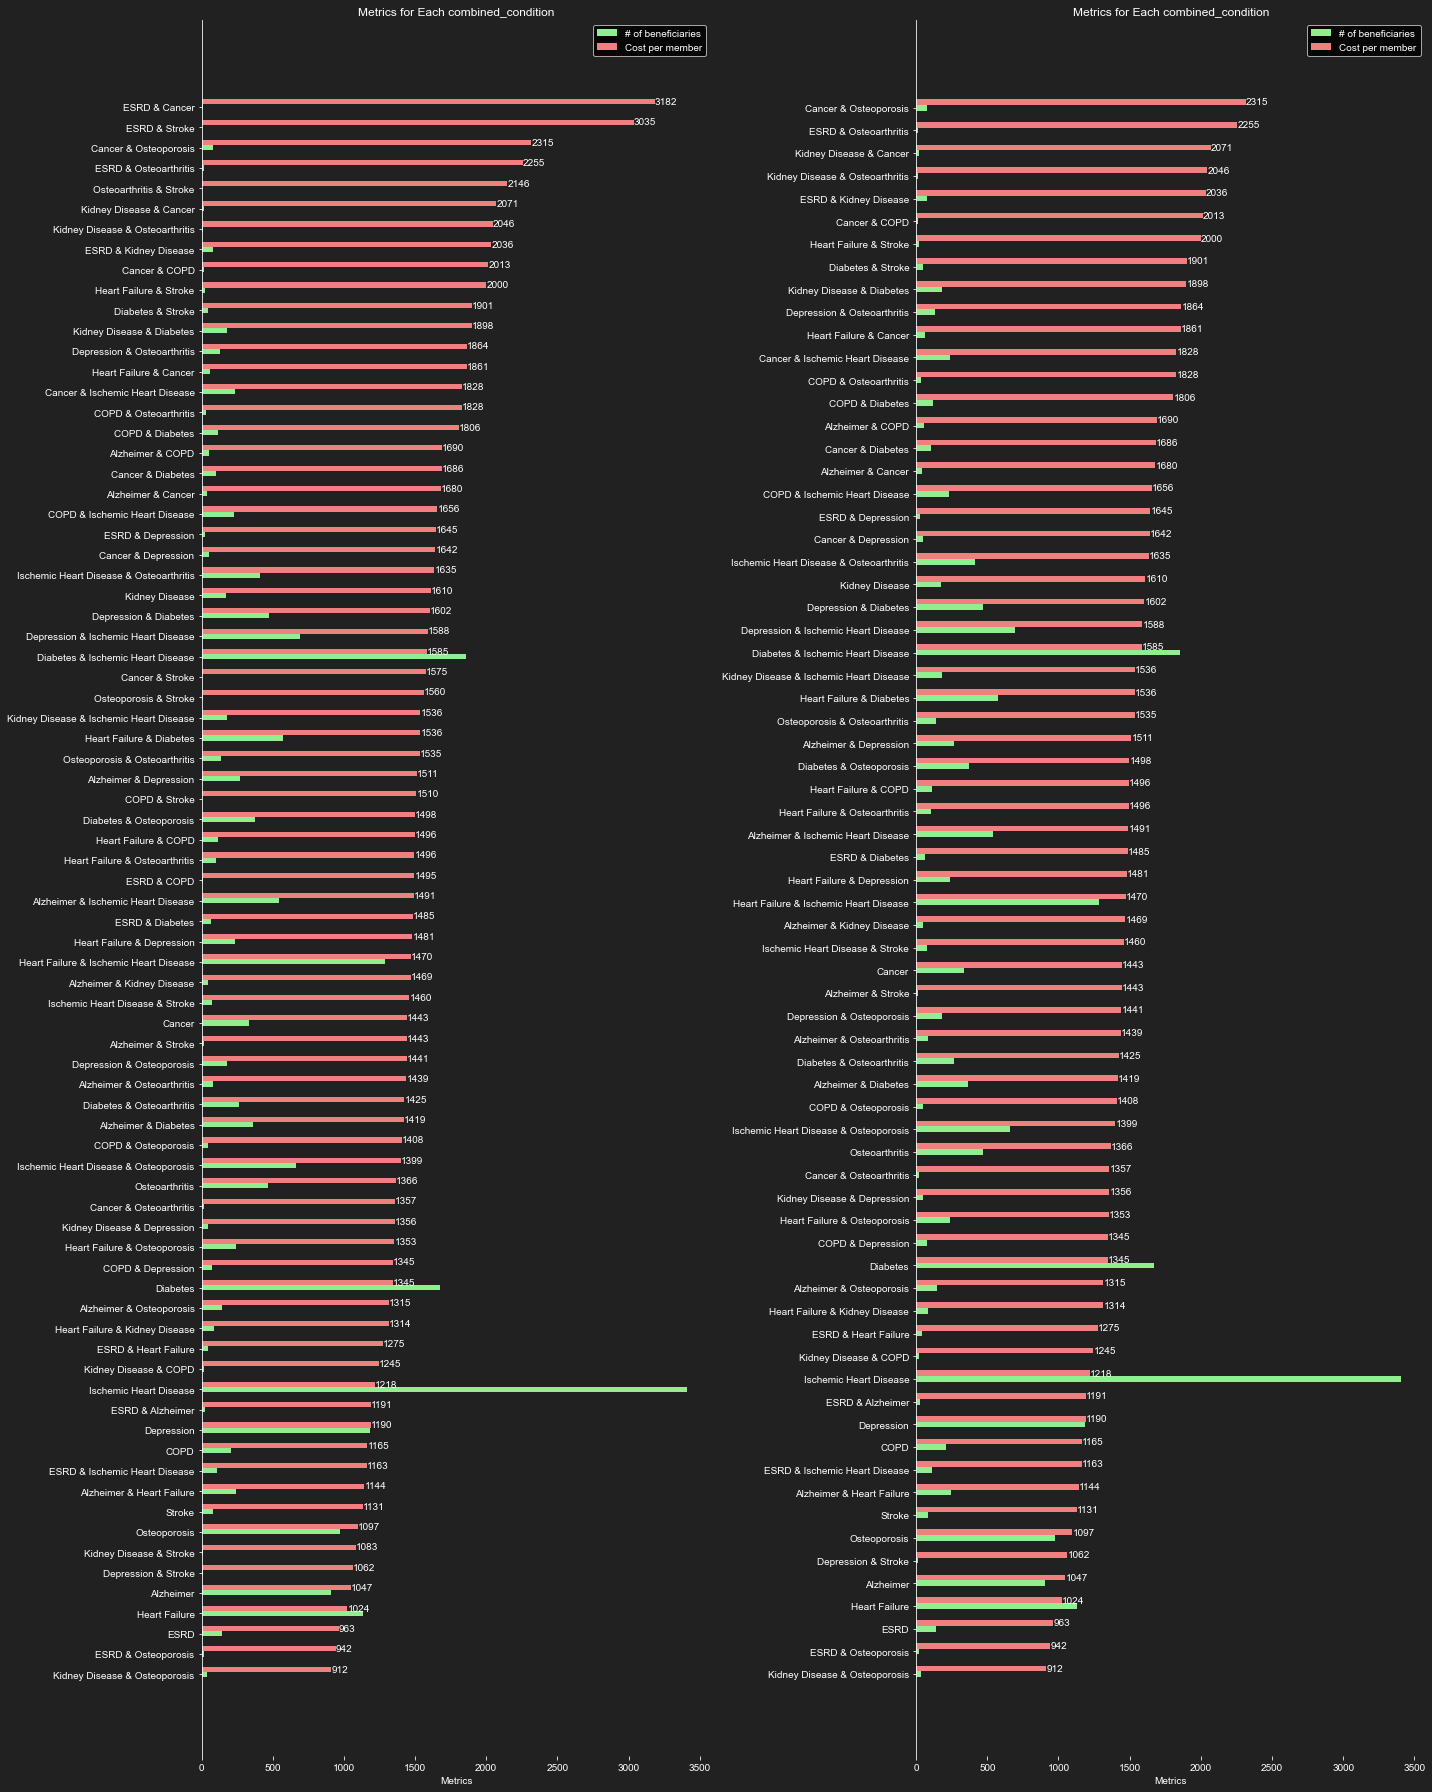

In [19]:

condition_grouped_df = get_cost_per_member(condition_grouped_df,
                                           'cost_per_member_per_illness')
condition_grouped_df_comb2 = get_2combination_illness(condition_grouped_df)

fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(20, 25),
    facecolor=SLIDE_BACKGROUND_COLOR
)

generate_clustered_column(condition_grouped_df_comb2,
                          'combined_condition', 
                          'cost_per_member_per_illness', 
                          'Cost per member',
                          'beneficiary_count',
                          '# of beneficiaries',
                          ax=axs[0])

threshold = condition_grouped_df_comb2['beneficiary_count'].quantile(.10)

condition_grouped_df_comb2_filtered = subset_df_with_greater_than(
    condition_grouped_df_comb2,
    'beneficiary_count',
    threshold)

generate_clustered_column(condition_grouped_df_comb2_filtered,
                          'combined_condition', 
                          'cost_per_member_per_illness', 
                          'Cost per member',
                          'beneficiary_count',
                          '# of beneficiaries',
                          ax=axs[1])
plt.tight_layout()
plt.show()

#### 5.2.4 Distribution of Cost per member across providers
The below represents the distribution across different providers, sorted by the 
inter quartile range. 

The graph on the right is recomputed after removing providers that have only 1 
beneficiary - this helps rule out outliers/ exceptional cases.

In [20]:
provider_condition_grouped_df = (beneficiary_claims_df
                                 .groupby(['AT_PHYSN_NPI', 'combined_condition'])
                                 .agg(total_cost=('CLM_PMT_AMT', 'sum'),
                                     beneficiary_count=('DESYNPUF_ID', 'nunique'),
                                    )
                                ).reset_index()


provider_condition_grouped_df = get_cost_per_member(
    provider_condition_grouped_df,
    'cost_per_member_per_provider_per_illness')


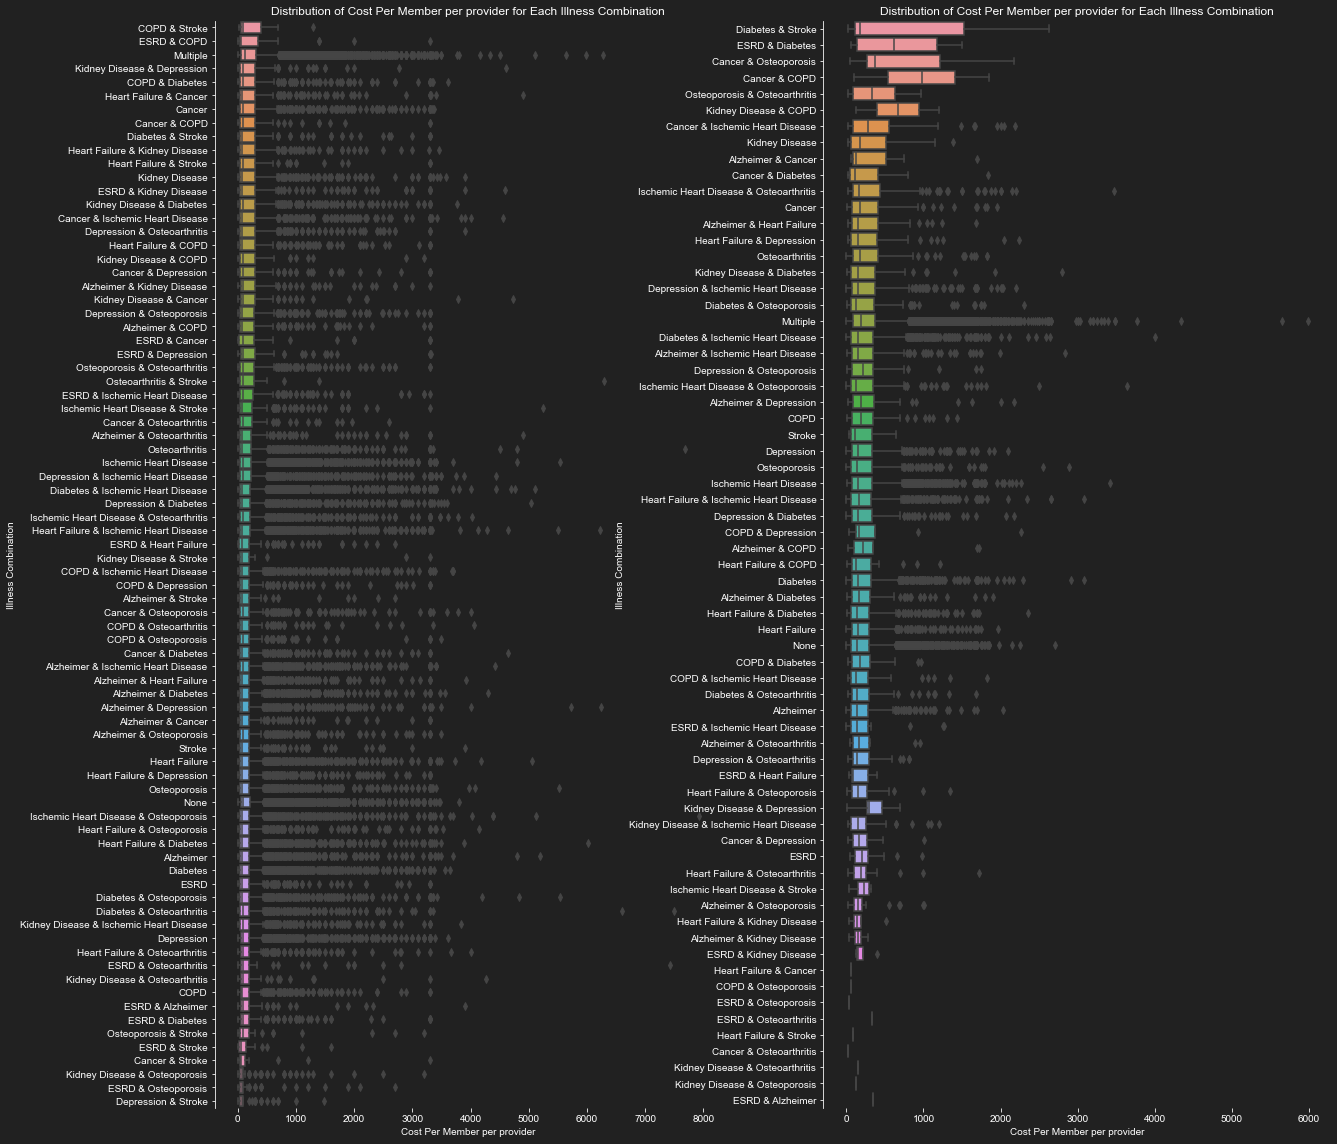

In [21]:

fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(20, 20),
    facecolor=SLIDE_BACKGROUND_COLOR
)
generate_boxplot(provider_condition_grouped_df,
                 'combined_condition',
                 'Illness Combination',
                 'cost_per_member_per_provider_per_illness',
                 'Cost Per Member per provider', axs[0])
provider_condition_grouped_df_filtered = subset_df_with_greater_than(
    provider_condition_grouped_df,
    'beneficiary_count',
    1)
                                        
generate_boxplot(provider_condition_grouped_df_filtered,
                 'combined_condition',
                 'Illness Combination',
                 'cost_per_member_per_provider_per_illness',
                 'Cost Per Member per provider', 
                 axs[1])

# Show the plot
plt.show()




### 6 Benchmarking

The aim here is to understand the distribution of cost across providers treating members with these chronic illnesses. Benchmarking providers across types of care is often a helpful starting point to begin solutioning for areas of high cost.

For each provider (use AT_PHYSN_NPI) & chronic illness, calculate the cost per member.
For each chronic illness combination, represent the distribution of costs per provider.
How does this change if we filter out cases where a given Chronic Illness & Provider NPI combination only has 1 member?
Which providers are consistently expensive across chronic illnesses they treat?


#### 6.2 Solution 1:
Retrieve providers that cost more than a THRESHOLD value. 
For the following analysis, only patients with either 1 chronic illness or a
combination of 2 chronic illnesses has been considered

Data frames to be used: 
- `provider_condition_grouped_df_filtered` - this has 
Cost per member aggregated at provider x illness combination, excluding providers
who have only 1 beneficiary
- `provider_grouped_df` - this has cost per member aggregated at provider level, 
excluding providers who have only 1 beneficiary


In [22]:
def calculate_savings(new_column, 
                      old_column):
    total_cost_2years = beneficiary_claims_df['CLM_PMT_AMT'].sum()
    absolute_difference = sum(old_column) - sum(new_column) 
    perc_difference = 100 * absolute_difference / total_cost_2years
    print(f'Perc difference in total cost: {round(perc_difference, 2)}%')
    absolute_difference_extrapolated = absolute_difference * (1 / SAMPLE_PERCENTAGE)
    print(f'Reduction in cost in 2yr period: {absolute_difference_extrapolated:,.0f}')


In [23]:
# Getting the base data for this ready
# Applying the 2 conditions: #beneficiaries > 1, 1-2 illnesses
beneficiary_claims_df_filtered = get_2combination_illness(beneficiary_claims_df)
provider_grouped_df = (
    beneficiary_claims_df.groupby('AT_PHYSN_NPI')
    .agg(
        total_cost=('CLM_PMT_AMT', 'sum'),
        beneficiary_count=('DESYNPUF_ID', 'nunique')
        ).reset_index()
)

provider_grouped_df = get_cost_per_member(provider_grouped_df,
                                          'cost_per_member_per_provider')


provider_grouped_df_filtered = subset_df_with_greater_than(
    provider_grouped_df,
    'beneficiary_count',
    1)


In [24]:
OVERALL_CPM_THRESHOLD = (
    provider_grouped_df_filtered['cost_per_member_per_provider']
    .quantile(0.95)
    )

In [25]:

solution1_df = (
    provider_grouped_df_filtered[
        provider_grouped_df_filtered['cost_per_member_per_provider'] >
        OVERALL_CPM_THRESHOLD
        ]
    )
solution1_df['optimised_CPM'] = OVERALL_CPM_THRESHOLD

solution1_df = get_optimised_cost(solution1_df)

calculate_savings(solution1_df['optimised_cost'], 
                  solution1_df['total_cost']
                  )                   


Perc difference in total cost: 1.73%
Reduction in cost in 2yr period: 71,843,240


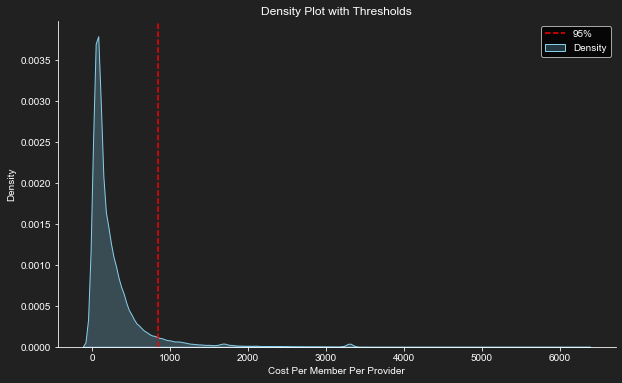

In [26]:
data = provider_grouped_df['cost_per_member_per_provider']


# line_value1 = 1500

# Create the density plot

fig, ax = plt.subplots(figsize=(10, 6), facecolor=SLIDE_BACKGROUND_COLOR)

sns.kdeplot(data, fill=True, color='skyblue', label='Density')

# Add vertical lines at the threshold and line_value1
plt.axvline(x=OVERALL_CPM_THRESHOLD, color='red', linestyle='--', label='95%')
# plt.axvline(x=line_value1, color='green', linestyle='--', label='75%')

# Set labels and title
plt.xlabel('Cost Per Member Per Provider')
plt.ylabel('Density')
plt.title('Density Plot with Thresholds')

ax.spines['top'].set_visible(False)   
ax.spines['right'].set_visible(False) 
ax.set_facecolor(SLIDE_BACKGROUND_COLOR) 


plt.legend()
plt.show()


However, we know that Costs per member vary greatly across conditions - between 900 and 3000. Using a blanket method is ignoring this variation.

##### 6.4 Solution 2
- The second solution is a refinement of the first, considering differences in 
various illness combinations. Below is a breakdown of this solution:

    - Step 1: Find providers that cost more than 95% of the 
    remaining providers in the conditions they treat.
    - Step 2: Assuming that these providers can be substituted for providers that are less than them with other providers treating the same condition
    
  Below are the potential results for the period of consideration for the analysis
  - Reduction in $s in period: 12,000,018
  - Percentage reduction in total cost: 0.2%

In [27]:
PERCENTILE_THRESHOLD = 0.95

In [28]:
provider_condition_grouped_df_filtered = get_2combination_illness(
    provider_condition_grouped_df_filtered
)

In [29]:

condition_grouped = (
    provider_condition_grouped_df_filtered
    .groupby(['combined_condition'])
    .agg(threshold_per_condition=('cost_per_member_per_provider_per_illness', 
                                  lambda x: x.quantile(PERCENTILE_THRESHOLD)))
    .reset_index()
)

merged_df = pd.merge(
    provider_condition_grouped_df_filtered,
    condition_grouped,
    on=['combined_condition'],
    how='inner'
)
expensive_providers = merged_df[
    merged_df['cost_per_member_per_provider_per_illness'] > 
    merged_df['threshold_per_condition']
    ]
expensive_providers['optimised_CPM'] = expensive_providers['threshold_per_condition']
expensive_providers = get_optimised_cost(expensive_providers)
calculate_savings(expensive_providers['optimised_cost'],
                  expensive_providers['total_cost']
                  )

Perc difference in total cost: 0.29%
Reduction in cost in 2yr period: 12,000,018


### References
1. CMS Linkable 2008–2010 Medicare DE-SynPUF [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/SynPUF_DUG.pdf]
2. Codebook for CMS Linkable 2008–2010 Medicare DE-SynPUF [https://www.cms.gov/files/document/de-10-codebook.pdf-0]
3. Race and Ethnicity in the US [https://www.census.gov/library/visualizations/interactive/race-and-ethnicity-in-the-united-state-2010-and-2020-census.html]

In [30]:
beneficiary_claims_df['CLM_PMT_AMT'].describe()

count   774693.00
mean       268.34
std        544.16
min          0.00
25%         40.00
50%         70.00
75%        200.00
max       3300.00
Name: CLM_PMT_AMT, dtype: float64

In [31]:
beneficiary_claims_df['CLM_PMT_AMT'].sum()

207878710.0

In [68]:
description = condition_grouped_df_comb2['cost_per_member_per_illness'].describe().to_frame()
description.columns = [
                       'value']
description.style.format(
    {
    'value': '{:,.0f}'}
)

,value
count,78
mean,"1,548"
std,399
min,912
25%,"1,345"
50%,"1,494"
75%,"1,675"
max,"3,182"
